In [96]:
from time import time
import yaml
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.optimize import approx_fprime, minimize
from scipy.integrate import simps

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

In [632]:
with open("x.yaml", "r") as file:
    x = yaml.load(file)
    
with open("y.yaml", "r") as file:
    y = yaml.load(file)

/Users/wayne.lee/miniconda3/envs/notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  
/Users/wayne.lee/miniconda3/envs/notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


In [612]:
type(x)

dict

In [613]:
len(x[1])

1000

In [614]:
irreps = list(x.keys())

In [615]:
irreps

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [633]:
to_dfs = lambda my_map: pd.DataFrame({key: my_map[key] for key in my_map})
x_df = to_dfs(x)
y_df = to_dfs(y)

In [881]:
def is_extreme(x, thresh=0.1):
    bounds = np.percentile(x, [thresh, 100 - thresh])
    return (x < bounds[0]) | (x > bounds[1])

In [907]:
def remove_extreme(df, thresh=0.1):
    extr_mat = df.apply(is_extreme, 0, thresh=thresh)
    any_extre = extr_mat.apply(any, 1)
    return df.loc[~any_extre,:]

In [883]:
y_df = remove_extreme(y_df)
x_df = remove_extreme(x_df)

In [742]:
# Long version of the data frame which is nice for graphing
dfs = [pd.DataFrame([{"x": xi, "y": yi, "irrep": k}
                     for xi, yi in zip(x[k], y[k])])
       for k in x]
df = pd.concat(dfs)

In [886]:
y_cov = np.cov(y_df.T)
x_cov = np.cov(x_df.T)

In [887]:
y_cov.shape

(16, 16)

#### The eigen values are not too small - condition number is not too large

In [888]:
np.linalg.eigvals(y_cov)

array([1.69804641e+00, 2.97439015e-01, 8.76999377e-02, 2.12926792e-02,
       1.67441733e-02, 1.32340371e-02, 1.10746561e-02, 6.71685964e-03,
       5.97567214e-03, 1.28106032e-03, 1.68618689e-03, 2.39011223e-03,
       2.63045635e-03, 5.04076626e-03, 4.09871967e-03, 4.31301726e-03])

In [889]:
np.linalg.eigvals(x_cov)

array([2.09912357e-04, 2.72233369e-05, 2.24894833e-05, 1.66155423e-05,
       1.09173506e-05, 1.03567600e-05, 8.46783762e-06, 8.68469241e-06,
       2.56540903e-06, 6.25862525e-06, 5.78611803e-06, 5.29608754e-06,
       5.02194944e-06, 4.48049472e-06, 2.86114866e-06, 3.85592658e-06])

In [890]:
y_avgs = y_df.mean()

In [891]:
y_df.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.338059,0.460118,0.184530,1.098172,0.233090,0.663361,0.180619,0.512536,0.313644,0.250325,0.571727,0.317052,0.320103,1.010166,0.344145,0.361741
1,0.207322,0.503118,0.203054,0.850276,0.323391,0.546566,0.049641,0.698921,0.370164,0.153134,0.660287,0.227176,0.347311,0.867895,0.435629,0.472706
2,0.286605,0.608619,0.120647,0.975858,0.333657,0.601397,0.224913,0.597816,0.296941,0.288718,0.626849,0.242085,0.471775,0.664171,0.419607,0.392133
3,0.315686,0.549046,0.186244,1.108152,0.431683,0.635867,0.200965,0.571647,0.361466,0.119846,0.612267,0.273368,0.460139,0.780685,0.491999,0.369155


In [892]:
y_avgs.head(5)

0    0.258938
1    0.559395
2    0.160908
3    1.049804
4    0.333639
dtype: float64

In [893]:
x_avgs = x_df.mean()
x_mat = sm.add_constant(x_avgs).to_numpy()

In [894]:
W = np.linalg.inv(y_cov)
XtWX = x_mat.T.dot(W).dot(x_mat)
wls_beta = np.linalg.inv(XtWX).dot(x_mat.T.dot(W).dot(y_avgs.to_numpy()))

In [895]:
wls_beta

array([0.08287115, 2.62708241])

In [896]:
xs = np.linspace(df.x.min(), df.x.max(), 1000)

(-2.0768685455309677, 2.997785081042233)

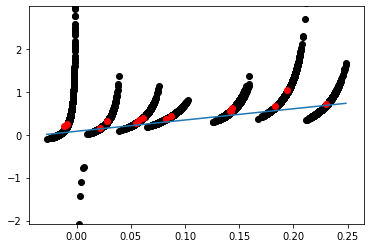

In [897]:
for irrep in irreps:
    plt.scatter(x[irrep], y[irrep], color="black")
plt.plot(xs, wls_beta[0] + wls_beta[1] * xs)
plt.scatter(x_avgs, y_avgs, color="red")
plt.ylim(np.percentile(df.y, [.1, 99.9]))

## Biggest mystery - why is the fitted line below most points?

The predictive distribution is
$\hat{Y} = X\hat{\beta}_{WLS} = X([X^T W X]^{-1}X^T W Y)$

Sanity check: $Cov(Y) = \Sigma = W^{-1}$
So $\hat{Y} = X\hat{\beta}_{WLS} = X([X^T W X]^{-1}X^T W Y) = X\beta + X[X^T W X]^{-1}X^T W \epsilon$
So $Cov(\hat{Y}) = X[X^T W X]^{-1}X^T W \Sigma W X [X^T W X]^{-1}X^T = X[X^T W X]^{-1}X^T W X [X^T W X]^{-1}X^T = X[X^T W X]^{-1}X^T$

In [790]:
def calc_lev(XtWX, x_mat):
    XtWX_inv = np.linalg.inv(XtWX)
    mat1 = x_mat.dot(XtWX_inv)
    hat_mat = mat1.dot(x_mat.T)
    lev = np.diag(hat_mat) / np.sum(np.diag(hat_mat)) * 100
    return lev

In [711]:
lev = calc_lev(XtWX, x_mat)

In [788]:
lev

array([ 3.43989081,  7.73880659,  3.09289485, 12.66598924,  3.0962824 ,
       11.44999963,  3.51289721,  7.60852764,  3.46847437,  3.47140854,
        7.79813413,  3.39477571,  3.53589707, 17.13956371,  4.3901301 ,
        4.196328  ])

In [869]:
np.where(lev > 10)

(array([ 3,  5, 13]),)

(-2.0768685455309677, 2.997785081042233)

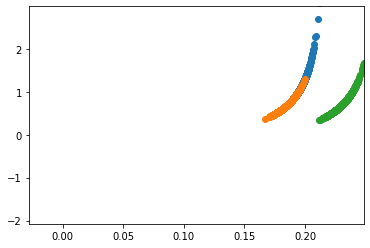

In [715]:
[plt.scatter(x[irrep], y[irrep]) for irrep, status in zip(irreps, lev > 10) if status]
plt.xlim([df.x.min(), df.x.max()])
plt.ylim(np.percentile(df.y, [.1, 99.9]))

In [733]:
low_lev = lev < 10

In [791]:
x_mat = sm.add_constant(x_avgs.loc[low_lev]).to_numpy()
W = np.linalg.inv(y_cov[:,low_lev][low_lev,:])
XtWX = x_mat.T.dot(W).dot(x_mat)
wls_beta = np.linalg.inv(XtWX).dot(x_mat.T.dot(W).dot(y_avgs.loc[low_lev].to_numpy()))

(-2.0768685455309677, 2.997785081042233)

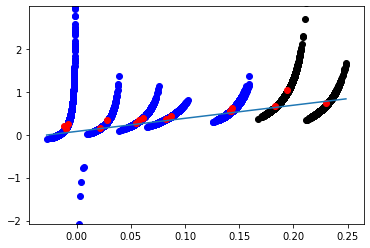

In [792]:
for irrep, low in zip(irreps, low_lev):
    if not low:
        plt.scatter(x[irrep], y[irrep], color="black")
    else:
        plt.scatter(x[irrep], y[irrep], color="blue")
plt.plot(xs, wls_beta[0] + wls_beta[1] * xs)
plt.scatter(x_avgs, y_avgs, color="red")
plt.ylim(np.percentile(df.y, [.1, 99.9]))

In [793]:
lev_drop = calc_lev(XtWX, x_mat)

In [805]:
#### Confirming that our code above did drop the right ones - checks out
lev_drop

array([ 6.59098014, 13.03275549,  5.37439754,  5.2709653 ,  6.79633369,
       12.78949623,  5.55385876,  6.68026024, 13.14366159,  5.45807984,
        5.64623273,  6.9927901 ,  6.67018835])

## Understanding the negative bias

In [806]:
x_avgs = x_df.mean()
x_mat = sm.add_constant(x_avgs).to_numpy()
W = np.linalg.inv(y_cov)
XtWX = x_mat.T.dot(W).dot(x_mat)
wls_beta = np.linalg.inv(XtWX).dot(x_mat.T.dot(W).dot(y_avgs.to_numpy()))

In [821]:
yhat = x_mat.dot(wls_beta)

In [826]:
yhat

array([0.05003933, 0.44558782, 0.12839486, 0.58072467, 0.14588466,
       0.5514709 , 0.04156582, 0.4412061 , 0.22363813, 0.04628203,
       0.44756285, 0.21453683, 0.23121221, 0.67486975, 0.29928053,
       0.28654556])

In [846]:
yhat <= y_avgs

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
dtype: bool

In [822]:
pre_y_mat = x_mat.dot(np.linalg.inv(XtWX).dot(x_mat.T.dot(W)))

In [834]:
i = 0
weighted_view = []
for i in range(len(irreps)):
    weighted_view.append(pre_y_mat[i, :] * y_avgs / yhat[i])
    
w_df = np.stack(weighted_view)

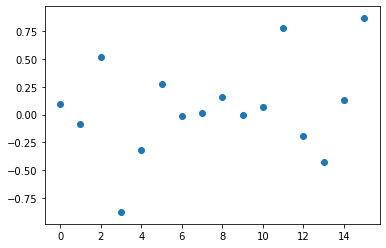

In [843]:
norm_weight_mean = np.apply_along_axis(np.mean, 0, w_df)
plt.scatter(range(len(irreps)), norm_weight_mean)

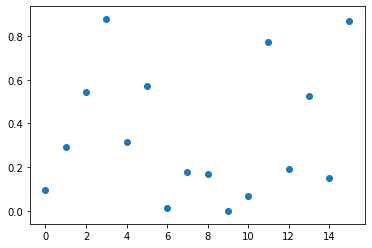

In [844]:
norm_abs_weight_mean = np.apply_along_axis(lambda x: np.mean(np.abs(x)), 0, w_df)
plt.scatter(range(len(irreps)), norm_abs_weight_mean)

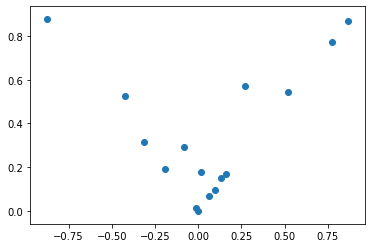

In [845]:
plt.scatter(norm_weight_mean, norm_abs_weight_mean)

In [812]:
np.where(~low_lev)

(array([ 3,  5, 13]),)

#### Notice the large negative term

In [857]:
y_cov[13, :] / y_cov[13, 13]

array([ 0.08883089,  0.35530046,  0.19392285,  0.83194127,  0.39813337,
        0.41831295,  0.92782037,  0.26900897,  0.27748288, -1.06950723,
        0.25823338,  0.24596702,  0.37062083,  1.        ,  0.1285092 ,
        0.25063272])

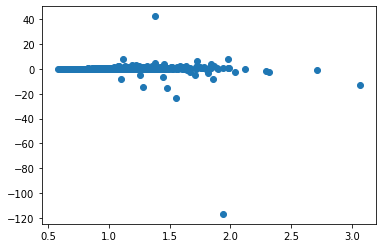

In [854]:
plt.scatter(y_df.iloc[:, 3], y_df.iloc[:, 9])

In [855]:
np.where(df.y[df.irrep == 9] < -80)

(array([674]),)

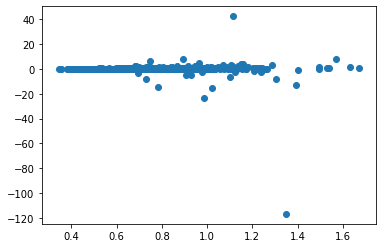

In [865]:
plt.scatter(y_df.iloc[:, 13], y_df.iloc[:, 9])

In [870]:
y_cov[-1, :] / y_cov[-1, -1]

array([ 0.31965002,  0.89103635,  0.48057994,  1.9970813 ,  0.99914996,
        0.98163423,  2.20757122,  0.78585502,  0.66087862, -1.74801495,
        0.81564584,  0.60559066,  0.88658293,  1.66889676,  0.58108805,
        1.        ])

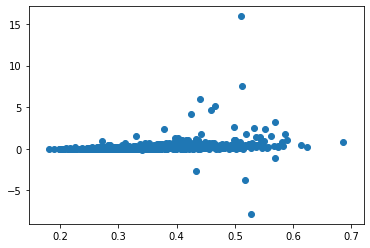

In [871]:
plt.scatter(y_df.iloc[:, -1], y_df.iloc[:, 6])

In [872]:
np.where(df.y[df.irrep == 6] > 15)

(array([407]),)

#### There are some outliers

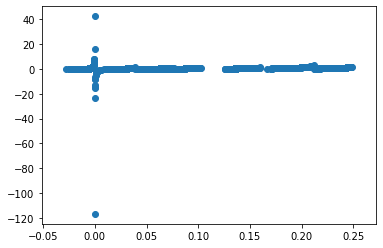

In [601]:
plt.scatter(df.x, df.y)
plt.show()

In [749]:
### There are around 37 "outliers"
df.loc[(df.y < -0.5) | (df.y > 3),:].shape

(37, 3)

After examining the histogram for the distribution in "x", these mostly seem Normal except for the 15th + 16th irreps.

(array([  8.,  19.,  85., 152., 212., 241., 176.,  72.,  32.,   3.]),
 array([0.06475477, 0.06815471, 0.07155466, 0.0749546 , 0.07835455,
        0.08175449, 0.08515443, 0.08855438, 0.09195432, 0.09535426,
        0.09875421]),
 <a list of 10 Patch objects>)

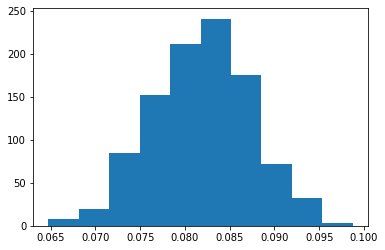

In [750]:
plt.hist(df.x[df.irrep == 15])

#### The correlation varies a bit (low and high both exist)

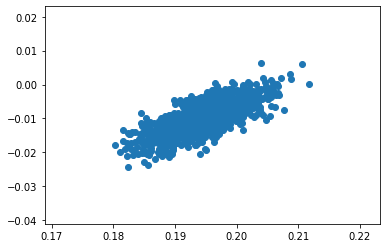

In [849]:
plt.scatter(df.x[df.irrep == 3], df.x[df.irrep == 9])

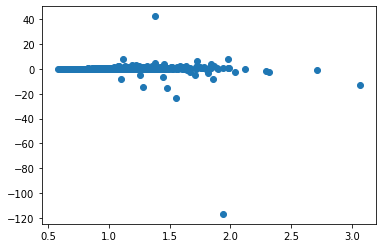

In [850]:
plt.scatter(df.x[df.irrep == 3], df.x[df.irrep == 9])

In [864]:
np.where(df.y[df.irrep == 9] < -80)

(array([674]),)

I'm assuming you know the function $f(x) = y$, but here I'm just going to approximate it with polynomials of $x$.

$$\hat{f}(x_i) = \alpha_0 + \alpha_1 * x_i + \alpha_2 * x_i^2 + \alpha_3 * x_i^3$$

In [754]:
def poly_reg(x, coeffs):
    x_poly = np.power(x.reshape(-1, 1), [0, 1, 2, 3, 4])
    
    return x_poly.dot(coeffs)

In [755]:
funs = {}
delta_funs = {}
for irrep in irreps:
    sub_df = df[df.irrep == irrep]
    x_poly = np.power(sub_df.x, [0, 1, 2, 3])
    ols_est = sm.OLS(sub_df.y, x_poly_w_const).fit()
    # It's important to define the defaults to force an evaluation in Python
    # Otherwise lazy evaluation will later only use the last set of parameters
    def fun_temp(x, coeff=ols_est.params):
        return(cubic_reg(x, coeff))
    #funs.update({irrep: lambda x: cubic_reg(x, coeffs=ols_est.params)})
    funs.update({irrep: fun_temp})
    
    def fun_temp(x, coeff=ols_est.params):
        return(cubic_reg(x, coeff))
    #funs.update({irrep: lambda x: cubic_reg(x, coeffs=ols_est.params)})
    funs.update({irrep: fun_temp})
    

#### TODO: Validate the regression fits

## Penalizing regression by distance along the curve

You have a deterministic transform for:
$y = f(x)$

And afterwards, you want to fit the regression by minimizing the squared distance between the line and the distance to $f(\bar{x})$ **along** $f()$.

We can then derive the gradient numerically to apply the Delta method.

In [756]:
def intersect(x, fun1, lin_fun2):
    if not isinstance(x, np.ndarray):
        x = np.array([x])
    out = np.empty(len(x))
        
    for i, xi in enumerate(x):
        opt = minimize(lambda z: np.power(fun1(z) - lin_fun2(z), 2),
                       xi, method="Nelder-Mead", options={"xatol":1e-8})
        assert opt.fun < 1e-8 or opt.success 
        out[i] = opt.x
        
    return out

In [757]:
def calc_length(point1, point2, fun, tol=1e-4):
    if point2 < point1:
        point_temp = point1
        point1 = point2
        point2 = point_temp
        
    steps = np.ceil((point2 - point1) / tol)
    xs1 = np.linspace(point1, point2, int(steps))
    xs2 = xs1
    dist = 0
    for x1, x2 in zip(xs1[:-1], xs2[1:]):
        x_sq_dist = np.power(x1 - x2, 2)
        y_sq_dist = np.power(fun(x2) - fun(x1), 2)
        dist += np.sqrt(x_sq_dist + y_sq_dist)
        
    return dist

In [758]:
funs = [funs[i] for i in rough_avgs.index]
eval_locs = rough_avgs.x
par = ols_start.params

In [804]:
def obj(par, eval_locs, funs, points=[]):
    # print(par)
    # points=[] is purely for debugging purposes
    def lin_fun(x):
        return par[0] + x * par[1]

    dists = []
    for xi, fi in zip(eval_locs, funs):
        new_x = intersect(np.array([xi]), fi, lin_fun)
        point = [new_x, fi(new_x)]
        points.append(point)
        dist = calc_length(new_x, xi, fi)
        # TODO: needs to weigh by the standard deviation
        
        dists.append(np.power(dist, 2))

    return np.sum(dists)

In [760]:
rough_avgs = df.groupby("irrep").mean()
rough_avg_x = sm.add_constant(rough_avgs.x)
ordered_funs = [funs[i] for i in rough_avgs.index]
ols_start = sm.OLS(rough_avgs.y, rough_avg_x).fit()

In [761]:
rough_avgs.head(3)

,x,y
irrep,,
0,-0.008523,0.261960
1,0.142788,0.560477
2,0.021450,0.161919


In [762]:
points = []
obj(ols_start.params, rough_avgs.x, ordered_funs, points)

0.21579597225468106

In [501]:
points[:3]

[[array([-0.01070764]), array([0.1643154])],
 [array([0.14585534]), array([0.61282613])],
 [array([0.02687983]), array([0.27039667])]]

#### Check the functions are finding the right spot

(-2.0768685455309677, 2.997785081042233)

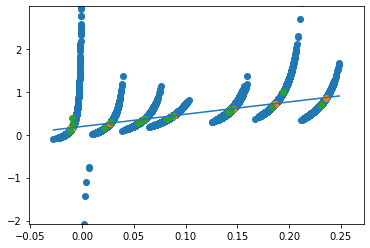

In [765]:
xy = np.concatenate(points, 1)
# Quick check on the points
xs = np.linspace(df.x.min(), df.x.max(), 1000)
plt.scatter(df.x, df.y)
plt.plot(xs, ols_start.params[0] + ols_start.params[1] * xs)
plt.scatter(xy[0, :], xy[1, :])
plt.scatter(rough_avgs.x, [funs[i](rough_avgs.loc[i].x) for i in rough_avgs.index])
plt.ylim(np.percentile(df.y, [.1, 99.9]))


In [766]:
a = time()
opt = minimize(obj, ols_start.params,
               args=(rough_avgs.x, ordered_funs),
               method='Nelder-Mead', options={"xatol":1e-8})
time() - a

8.926475048065186

In [767]:
opt

 final_simplex: (array([[0.20253239, 2.60582149],
       [0.20253239, 2.60582149],
       [0.20253239, 2.60582148]]), array([0.20432228, 0.20432228, 0.20432228]))
           fun: 0.2043222789626963
       message: 'Optimization terminated successfully.'
          nfev: 116
           nit: 49
        status: 0
       success: True
             x: array([0.20253239, 2.60582149])

In [768]:
best_est = opt.x

In [769]:
def x_vec_to_slope(x_vec):
    opt = minimize(obj, ols_start.params,
                   args=(x_vec, ordered_funs),
                   method="Nelder-Mead", options={"xatol":1e-8})
    assert opt.success
    return(opt.x[1])

def x_vec_to_intercept(x_vec):
    opt = minimize(obj, ols_start.params,
                   args=(x_vec, ordered_funs),
                   method="Nelder-Mead", options={"xatol":1e-8})
    assert opt.success
    return(opt.x[0])

In [770]:
grad_slope = approx_fprime(rough_avgs.x, x_vec_to_slope, 1e-4)

In [771]:
grad_slope

array([-47.17083127,  11.3464356 ,  -6.9353569 ,  40.35427215,
       -27.60462093,  23.81951807, -58.19845711,   9.97291737,
        -4.40278996, -84.5441324 ,  12.66810617, -12.60161158,
        -2.32540169,  41.72806905,  -6.13834501,   7.64363975])

In [772]:
grad_inter = approx_fprime(rough_avgs.x, x_vec_to_intercept, 1e-4)

In [773]:
grad_inter

array([ 6.80896052, -0.60887598,  1.65241163, -1.29080286,  4.41999339,
       -0.60901122,  8.28526701,  0.19180278,  1.6425481 , 12.03712695,
        0.56858082,  2.33610664,  1.86797843, -1.42536475,  2.24734517,
        0.24294447])

In [774]:
grad = np.stack([grad_inter, grad_slope]).T

In [775]:
grad.shape

(16, 2)

#### Delta Method says

If you have
$\begin{bmatrix}\bar{X}_1 \\ \vdots \\ \bar{X}_k \end{bmatrix} \to MVN\left(\begin{bmatrix}\mu_1 \\ \vdots \\ \mu_k \end{bmatrix}, \Sigma\right)$

Which you seem to have, then

$$g\left(\begin{bmatrix}\bar{X}_1 \\ \vdots \\ \bar{X}_k \end{bmatrix}\right) - g\left(\begin{bmatrix}\mu_1 \\ \vdots \\ \mu_k \end{bmatrix}\right) \stackrel{n\to \infty}{\Rightarrow} N\left(0, \underbrace{\nabla g\binom{\mu_x(e)}{\mu_y(e)}^T \Sigma \nabla g\binom{\mu_x(e)}{\mu_y(e)}}_{=\sigma^2_g(e)}\right)$$

In [776]:
df.tail(3)

,x,y,irrep
997,0.088338,0.455209,15
998,0.085159,0.403970,15
999,0.075580,0.281854,15


In [778]:
delta_cov = grad.T.dot(x_cov).dot(grad)

In [779]:
L = np.linalg.cholesky(delta_cov)
xs = np.linspace(df.x.min(), df.x.max(), 500)
pred_vals = []
for i in range(sim_num):
    noise = np.random.normal(0, 1, 2)
    coeff_sample = L.dot(noise) + best_est
    pred_vals.append(coeff_sample[0] + xs * coeff_sample[1])
    
pred_vals_df = np.stack(pred_vals)

In [780]:
pred_vals_df.shape

(10, 500)

In [781]:
bounds = np.apply_along_axis(lambda x: np.percentile(x, [2.5, 97.5]),
                             0, pred_vals_df)

In [782]:
bounds.shape

(2, 500)

(-2.0768685455309677, 2.997785081042233)

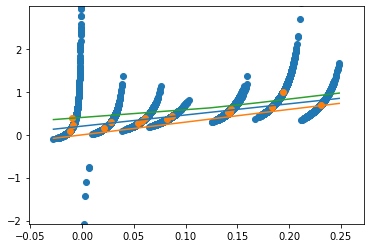

In [783]:
plt.scatter(df.x, df.y)
plt.plot(xs, best_est[0] + best_est[1] * xs)
plt.scatter(rough_avgs.x, [funs[i](rough_avgs.loc[i].x) for i in rough_avgs.index])
plt.plot(xs, bounds[0, :])
plt.plot(xs, bounds[1, :])
plt.ylim(np.percentile(df.y, [.1, 99.9]))

### I don't really trust the numerically derived gradient....

In [795]:
def x_vec_to_params(x_vec):
    opt = minimize(obj, ols_start.params,
                   args=(x_vec, ordered_funs),
                   method="Nelder-Mead", options={"xatol":1e-8})
    assert opt.success
    return opt.x

In [903]:
sim_num = 100
boot_params = []
for i in range(sim_num):
    boot_inds = np.random.choice(1000, 1, replace=True)
    boot_avg = []
    for irrep, sub_df in df.groupby("irrep"):
        boot_avg.append(sub_df.iloc[boot_inds, :].x)
    boot_param = x_vec_to_params(np.concatenate(boot_avg))
    boot_params.append(boot_param)

In [904]:
pred_vals = []
xs = np.linspace(df.x.min(), df.x.max(), 500)

for i in range(sim_num):
    boot_param = boot_params[i]
    pred_vals.append(boot_param[0] + xs * boot_param[1])

In [905]:
pred_vals_df = np.stack(pred_vals)
bounds = np.apply_along_axis(lambda x: np.percentile(x, [10, 90]),
                             0, pred_vals_df)

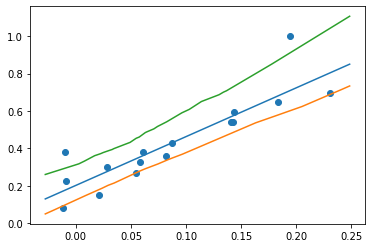

In [906]:
#plt.scatter(df.x, df.y)
plt.plot(xs, best_est[0] + best_est[1] * xs)
plt.scatter(rough_avgs.x, [funs[i](rough_avgs.loc[i].x) for i in rough_avgs.index])
plt.plot(xs, bounds[0, :])
plt.plot(xs, bounds[1, :])
#plt.ylim(np.percentile(df.y, [.1, 99.9]))